In [1]:
import numpy as np
from netCDF4 import Dataset, num2date # to work with NetCDF files
from os.path import expanduser
import matplotlib.pyplot as plt
home = expanduser("~") # Get users home directory
import statsmodels.api as sm
from scipy import stats

import xarray as xr
import pytz
import glob, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt     
import matplotlib.dates as mdates
import datetime
from dateutil import tz
import metpy.calc as mpcalc
from metpy.units import units

import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
import matplotlib.colors as colors
import matplotlib.cm as cmx

matplotlib.rcParams.update({'font.size': 22})



In [ ]:
dir_profile = "/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/Input/Products/"

path_to_sonde_profiles = os.path.join(dir_profile,"rad_profiles_all_sondes_ERA.nc")
#path_to_radiosonde_profiles = os.path.join(dir_profile,"rad_profiles_radiosondes","rad_profiles.nc")

#path_to_dropsonde_profiles = os.path.join(dir_profile,"rad_profiles_all_dropsondes.nc")
#path_to_radiosonde_profiles = os.path.join(dir_profile, "rad_profiles_all_radiosondes.nc")

# Load profiles

In [ ]:
sonde_profiles = xr.open_dataset(path_to_sonde_profiles)

# Mean profiles

In [4]:
def get_relative_humidity(profiles):
    
    profiles["play"].attrs['units'] = 'hPa'
    profiles["tlay"].attrs['units'] = 'kelvin'
    
    rh = mpcalc.relative_humidity_from_mixing_ratio(profiles["mr"], profiles["tlay"], profiles["play"])
    
    profiles["rh"] = (["launch_time","zlay"], rh.magnitude)  #volume to mass mixing ratio
    
    
    return profiles

In [5]:
def get_specific_humidity(profiles):
        
    qv = mpcalc.specific_humidity_from_mixing_ratio(profiles["mr"])
    
    profiles["qv"] = (["launch_time","zlay"], qv.magnitude)  #volume to mass mixing ratio
    
    return profiles

In [6]:
def plot_average_profiles(profiles):
    
    plt.rcParams.update({'font.size': 24})

    profiles = get_relative_humidity(profiles)
    profiles = get_specific_humidity(profiles)
       
    tlay_mean = profiles["tlay"].quantile(0.5, dim="launch_time")
    tlay_fq = (profiles["tlay"]).quantile(0.25, dim="launch_time")
    tlay_lq = (profiles["tlay"]).quantile(0.75, dim="launch_time")

    qv_mean = profiles["qv"].quantile(0.5, dim="launch_time")*1000
    qv_fq = (profiles["qv"]).quantile(0.25, dim="launch_time")*1000
    qv_lq = (profiles["qv"]).quantile(0.75, dim="launch_time")*1000
    
    rh_mean = profiles["rh"].quantile(0.5, dim="launch_time")
    rh_fq = (profiles["rh"]).quantile(0.25, dim="launch_time")
    rh_lq = (profiles["rh"]).quantile(0.75, dim="launch_time")

    q_rad_mean = profiles["q_rad"].quantile(0.5, dim="launch_time")
    q_rad_fq = profiles["q_rad"].quantile(0.25, dim="launch_time")
    q_rad_lq = profiles["q_rad"].quantile(0.75, dim="launch_time")
  
    q_rad_lw_mean = profiles["q_rad_lw"].quantile(0.5, dim="launch_time")
    q_rad_lw_fq = profiles["q_rad_lw"].quantile(0.25, dim="launch_time")
    q_rad_lw_lq = profiles["q_rad_lw"].quantile(0.75, dim="launch_time")
    
    q_rad_sw = profiles["q_rad_sw"].where(profiles["q_rad_sw"].mean(dim="zlay") > 0, drop=True)
    
    q_rad_sw_mean = q_rad_sw.quantile(0.5, dim="launch_time", skipna=True)
    q_rad_sw_fq = q_rad_sw.quantile(0.25, dim="launch_time", skipna=True)
    q_rad_sw_lq = q_rad_sw.quantile(0.75, dim="launch_time", skipna=True)
    
    zlay = profiles["zlay"]/1000
    
    fig, ax = plt.subplots(2,3,figsize=(20,20))
    
    ax[0,0].set_xlabel('Temperature (K)')
    ax[0,1].set_xlabel('Specific humidity (g/kg)')
    ax[0,2].set_xlabel('Relative humidity (%)')
    
    ax[0,0].set_ylabel('Altitude (km)')
    ax[1,0].set_ylabel('Altitude (km)')

    
    fs=24
    ax[0,1].set_title('Environmental means', fontsize=fs)
    ax[1,0].set_title('Shortwave', fontsize=fs)
    ax[1,1].set_title('Longwave', fontsize=fs)
    ax[1,2].set_title('Net', fontsize=fs)

    ax[1,1].set_xlabel('Heating rates (K/day)')
    
    ymin=0
    ymax=10
    for k in range(3):
        ax[1,k].set_xlim([-4.9,4.9])
        for i in range (2):
            ax[i,k].grid(color='k', linestyle='--', linewidth=0.8)
            ax[i,k].set_ylim([ymin,ymax]) 
            ax[i,k].tick_params(direction='in', bottom=True, top=True, left=True, right=True,grid_alpha=0.6)
            for axis in ['top','bottom','left','right']:
                ax[i,k].spines[axis].set_linewidth(1.3)
            ax[i,k].spines['right'].set_visible(False)
            ax[i,k].spines['top'].set_visible(False)
        
    cl= "k"
    alpha=0.20
    
    ax[0,0].fill_betweenx(zlay,tlay_fq, tlay_lq, alpha=alpha, color=cl)    
    ax[0,0].plot(tlay_mean, zlay, color=cl)
#     ax[0].set_xlim([0,100])

    ax[0,1].fill_betweenx(zlay,qv_fq, qv_lq, alpha=alpha, color=cl)    
    ax[0,1].plot(qv_mean, zlay, color=cl)
    
    ax[0,2].fill_betweenx(zlay,rh_fq, rh_lq, alpha=alpha, color=cl)    
    ax[0,2].plot(rh_mean, zlay, color=cl)
    
    ax[1,0].fill_betweenx(zlay,q_rad_sw_fq, q_rad_sw_lq, alpha=alpha, color=cl)    
    ax[1,0].plot(q_rad_sw_mean, zlay, color=cl)
#     ax[0].set_xlim([0,100])

    ax[1,1].fill_betweenx(zlay,q_rad_lw_fq, q_rad_lw_lq, alpha=alpha, color=cl)    
    ax[1,1].plot(q_rad_lw_mean, zlay, color=cl)
    
    ax[1,2].fill_betweenx(zlay,q_rad_fq, q_rad_lq, alpha=alpha, color=cl)    
    ax[1,2].plot(q_rad_mean, zlay, color=cl)
    
    x_text=0.8
    y_text=0.9
    ax[0,0].text(x_text,y_text,'(a)',transform = ax[0,0].transAxes,fontsize=fs)
    ax[0,1].text(x_text,y_text,'(b)',transform = ax[0,1].transAxes,fontsize=fs)
    ax[0,2].text(x_text,y_text,'(c)',transform = ax[0,2].transAxes,fontsize=fs)
    ax[1,0].text(x_text,y_text,'(d)',transform = ax[1,0].transAxes,fontsize=fs)
    ax[1,1].text(x_text,y_text,'(e)',transform = ax[1,1].transAxes,fontsize=fs)
    ax[1,2].text(x_text,y_text,'(f)',transform = ax[1,2].transAxes,fontsize=fs)

    
#     ax[1].tick_params(labelleft=False) 
    
    fig.savefig('../Figures/average_profiles.jpg')

/home/ludo/anaconda3/envs/my_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ludo/anaconda3/envs/my_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


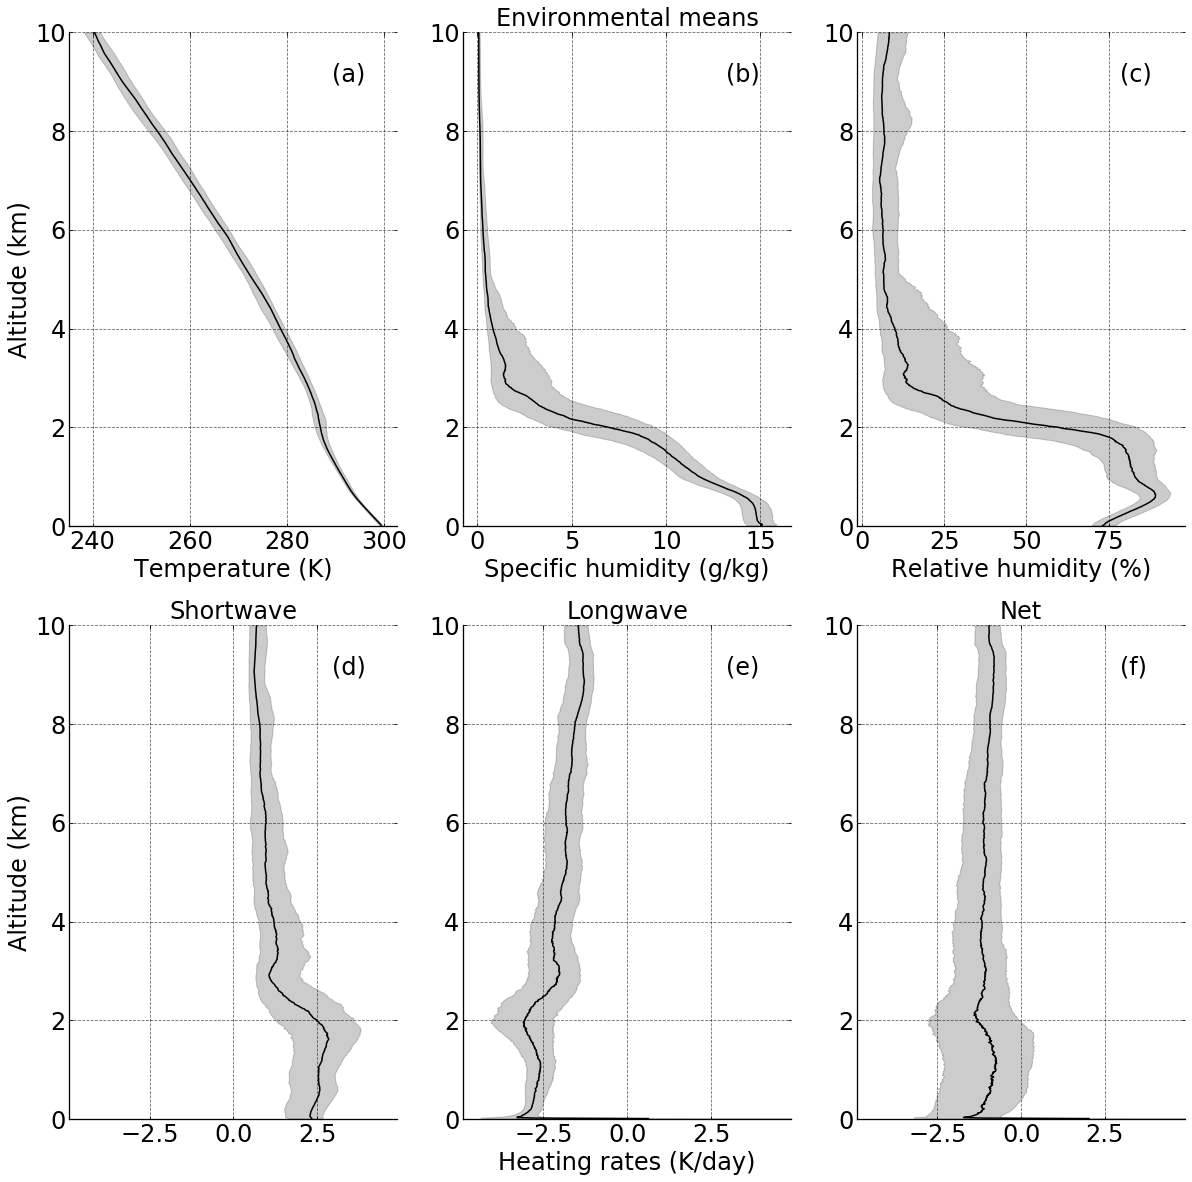

In [7]:
plot_average_profiles(sonde_profiles)

# Diurnal cycle

In [8]:
def get_variables_to_plot(profiles):
    
    #get only some coordinates of the original xarray
    data = profiles["q_rad"]  
    data["q_rad_lw"] = profiles["q_rad_lw"]
    data["q_rad_sw"] = profiles["q_rad_sw"]
    data["time"] = profiles["launch_time"]
    data = data.drop_vars(["lay","col"])
    
    data = data.to_dataframe()
    data["time"] = data["time"].dt.tz_localize(pytz.UTC).dt.tz_convert('America/Barbados').dt.strftime("%H:%M")
    
    data["time"] = pd.to_datetime(data["time"], format="%H:%M")

    data = data.reset_index()
    data = data.set_index(["time","zlay"])
    data = data.groupby([pd.Grouper(freq='10min', level='time'), 
                                 pd.Grouper(level='zlay')]).mean()
        
    #come back to xarray and get q_rad
    data = data.to_xarray()
    time = data.time.values
    zlay = data.zlay.values
        
    #fill values with 0 in a new array
    ini = np.datetime64('1900-01-01 00:00:00')
    end = ini + np.timedelta64(24,'h')
    count_time = np.arange(ini, end, np.timedelta64(10, 'm'))

    q_rad = np.zeros((len(count_time), len(zlay)))
    q_rad_sw = np.zeros((len(count_time), len(zlay)))
    q_rad_lw = np.zeros((len(count_time), len(zlay)))

    ds =  xr.Dataset({'q_rad': (['count_time', 'zlay'],  q_rad),
                       'q_rad_sw': (['count_time', 'zlay'],  q_rad_sw),
                        'q_rad_lw': (['count_time', 'zlay'],  q_rad_lw)},
                    coords={"count_time": count_time, "zlay": zlay})

    array = ds.to_dataframe()

    for itime in time:
        print(itime)
        for izlay in zlay:
            array.q_rad.loc[itime, izlay] = data["q_rad"].sel(time=itime).sel(zlay=izlay).values
            array.q_rad_lw.loc[itime, izlay] = data["q_rad_lw"].sel(time=itime).sel(zlay=izlay).values
            array.q_rad_sw.loc[itime, izlay] = data["q_rad_sw"].sel(time=itime).sel(zlay=izlay).values

    print(array)        
    
    data = array.to_xarray()
    
    q_rad = np.transpose(data.q_rad.values)
    q_rad_lw = np.transpose(data.q_rad_lw.values)
    q_rad_sw = np.transpose(data.q_rad_sw.values)
    zlay = data.zlay.values
    time = data.count_time.values
    
    print(data)

    
    return time, zlay, q_rad, q_rad_lw, q_rad_sw

In [ ]:
time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_to_plot(sonde_profiles) 

1900-01-01T00:00:00.000000000
1900-01-01T00:10:00.000000000
1900-01-01T00:20:00.000000000
1900-01-01T00:30:00.000000000
1900-01-01T00:40:00.000000000
1900-01-01T00:50:00.000000000
1900-01-01T01:00:00.000000000
1900-01-01T01:10:00.000000000
1900-01-01T01:20:00.000000000
1900-01-01T01:30:00.000000000
1900-01-01T01:40:00.000000000
1900-01-01T01:50:00.000000000
1900-01-01T02:00:00.000000000
1900-01-01T02:10:00.000000000
1900-01-01T02:20:00.000000000
1900-01-01T02:30:00.000000000
1900-01-01T02:40:00.000000000
1900-01-01T02:50:00.000000000
1900-01-01T03:00:00.000000000
1900-01-01T03:10:00.000000000
1900-01-01T03:20:00.000000000
1900-01-01T03:30:00.000000000
1900-01-01T03:40:00.000000000
1900-01-01T04:00:00.000000000
1900-01-01T04:10:00.000000000
1900-01-01T04:20:00.000000000
1900-01-01T04:30:00.000000000
1900-01-01T04:40:00.000000000
1900-01-01T04:50:00.000000000
1900-01-01T05:00:00.000000000
1900-01-01T05:10:00.000000000
1900-01-01T05:20:00.000000000
1900-01-01T05:30:00.000000000
1900-01-01

In [ ]:
def plot_diurnal_cycle(time, zlay, q_rad_lw, q_rad_sw, q_rad):
    
#     time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_to_plot(profiles)   
 
    dates_list = [date for date in time]    
        
    fig, ax = plt.subplots(1,3,figsize=(20,10))
    
    ax[0].set_title(r'Shortwave')
    ax[0].set_ylabel('Altitude (km)')
                
    ax[1].set_title('Longwave')
    ax[1].set_xlabel('Time (Local)')


    ax[2].set_title(r'Net')

    ymin=0
    ymax=10
    
    colormap = matplotlib.cm.get_cmap("RdBu_r")
#     colormap.set_bad(color='gray')
    val_min = -4
    val_max = 4

    zlay=zlay/1000
    
    ax[0].pcolormesh(dates_list, zlay, q_rad_sw, cmap=colormap,vmin=val_min, vmax=val_max)
    ax[1].pcolormesh(dates_list, zlay, q_rad_lw, cmap=colormap,vmin=val_min,vmax=val_max)
    im = ax[2].pcolormesh(dates_list, zlay, q_rad, cmap=colormap,vmin=val_min, vmax=val_max)
    
    myFmt = mdates.DateFormatter('%-H')
    
    for k in range(3):
        ax[k].xaxis.set_major_formatter(myFmt)
        ax[k].set_ylim([0,ymax])
    

    for k in range(3):
        ticks = ax[k].get_xticks()
        ax[k].set_xticks(np.linspace(ticks[0], mdates.date2num(mdates.num2date(ticks[-1])), 4))

    ax[1].tick_params(labelleft=False)    
    ax[2].tick_params(labelleft=False)    

    cb = fig.colorbar(im, ax=ax[2], extend="both")
    cb.ax.set_ylabel('Heating Rate (K/day)')
    
   # fig.tight_layout() 
    
  #  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    
    fig.savefig('../Figures/diurnal_cycle.jpg')    

In [ ]:
plot_diurnal_cycle(time, zlay, q_rad_sw, q_rad_lw, q_rad)

# Day to day variability

In [ ]:
def get_variables_day_to_day(profiles):
#     profiles = profiles.sel(launch_time="2020-02-02")
    #get only some coordinates of the original xarray
    data = profiles["q_rad"]
    data["q_rad_sw"] = profiles["q_rad_lw"]
    data["q_rad_lw"] = profiles["q_rad_sw"]

    data["time"] = profiles["launch_time"]
    data = data.drop_vars(["lay","col"])
    
    data = data.to_dataframe()
    data["time"] = data["time"].dt.tz_localize(pytz.UTC).dt.tz_convert('America/Barbados').dt.strftime("%Y%m%dT%H")
    
    data["time"] = pd.to_datetime(data["time"], format="%Y%m%dT%H")

    data = data.reset_index()
    data = data.set_index(["time","zlay"])
    data = data.groupby([pd.Grouper(freq='1H', level='time', label="right"), 
                                 pd.Grouper(level='zlay')]).mean()
    
    #come back to xarray and get q_rad
    data = data.to_xarray()
    
    time = data.time.values
    zlay = data.zlay.values
    q_rad = np.transpose(data.q_rad.values)
    q_rad_sw = np.transpose(data.q_rad_lw.values)
    q_rad_lw = np.transpose(data.q_rad_sw.values)

    return time, zlay, q_rad, q_rad_lw, q_rad_sw

In [ ]:
sonde_BCO = sonde_profiles.where(sonde_profiles.platform=="BCO", drop=True)

In [ ]:
time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_day_to_day(sonde_BCO)

In [ ]:
def plot_day_to_day(time, zlay, q_rad_sw, q_rad_lw, q_rad):
    
#     time, zlay, q_rad, q_rad_lw, q_rad_sw = get_variables_to_plot(profiles)   
 
    dates_list = [date for date in time]    
        
    fig, ax = plt.subplots(3,1,figsize=(20,30))
    
    fig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

    pad=10
    fs=25
    loc="left"
    fw="bold"
    ax[0].set_title(r'a) Shortwave', loc=loc, pad=pad,fontsize=fs, fontweight=fw)
    ax[1].set_title(r'b) Longwave', loc=loc, pad=pad, fontsize=fs, fontweight=fw)
    ax[2].set_title(r'c) Net', loc=loc, pad=pad, fontsize=fs, fontweight=fw)

    ax[1].set_ylabel('Altitude (km)')
    ax[2].set_xlabel('Date')

    ymin=0
    ymax=10
    
    colormap = matplotlib.cm.get_cmap("RdBu_r")
#     colormap.set_bad(color='gray')
    val_min = -4
    val_max = 4

    zlay=zlay/1000
    
    ax[0].pcolormesh(dates_list, zlay, q_rad_sw, cmap=colormap,vmin=val_min, vmax=val_max)
    ax[1].pcolormesh(dates_list, zlay, q_rad_lw, cmap=colormap,vmin=val_min, vmax=val_max)
    im = ax[2].pcolormesh(dates_list, zlay, q_rad, cmap=colormap,vmin=val_min, vmax=val_max)

    myFmt = mdates.DateFormatter('%m-%d')
    
    ini = np.datetime64('2020-01-19 00:00:00')
    end = np.datetime64('2020-02-17 00:00:00')
    
    for k in range(3):
        ax[k].xaxis.set_major_formatter(myFmt)
        ax[k].set_ylim([0,ymax])
        ax[k].set_xlim([ini,end])

    for k in range(3):
        ticks = ax[k].get_xticks()
        ax[k].set_xticks(np.linspace(ticks[0], ticks[-1], 10))

#       mdates.date2num(mdates.num2date(ticks[-1])), 10))

#     ax.tick_params(labelleft=False)    
#     ax.tick_params(labelleft=False)    

    x,y,w,h = ax[2].get_position().bounds
    c_map_ax = fig.add_axes([x, y-0.25*h, 1*w, 0.06*h])
    cbar = fig.colorbar(im,cax=c_map_ax, orientation="horizontal", extend="both")
    cbar.ax.set_xlabel('Heating Rate (K/day)',color='k') # cbar legend
    
   # fig.tight_layout() 
    
  #  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    
    fig.savefig('../Figures/day_to_day_variability.jpg')    

In [ ]:
plot_day_to_day(time, zlay, q_rad_sw, q_rad_lw, q_rad)
